In [1]:
import os 
import re

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import sklearn.model_selection
import sklearn.tree

In the previous notebook, we did the data cleaning on the board game data downloaded from BoardGameGeek website. In this notebook, we will try to model the data to see if we could use it to predict if a game is owned by many people.

# Read data in and explore the basic information

In [2]:
games = pd.read_csv('./data/games_detail_cleaned.csv')

In [3]:
games.shape

(44564, 155)

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44564 entries, 0 to 44563
Columns: 155 entries, id to Zombies
dtypes: float64(10), int64(143), object(2)
memory usage: 52.7+ MB


In [5]:
games.describe()

,id,n_names,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,...,Transportation,Travel,Trivia,Video Game Theme,Vietnam War,Wargame,Word Game,World War I,World War II,Zombies
count,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,...,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000,44564.000000
mean,79238.000942,1.554753,2001.083206,2.055269,5.926932,68.359034,60.998743,68.359034,7.895838,196.204313,...,0.016022,0.015999,0.049659,0.008707,0.002670,0.149560,0.028184,0.008527,0.044363,0.008639
std,68164.220203,4.437296,15.888733,0.727093,73.117442,446.678216,429.529777,446.678216,4.491565,1382.883221,...,0.125561,0.125474,0.217242,0.092903,0.051607,0.356644,0.165501,0.091949,0.205903,0.092546
min,1.000000,1.000000,1901.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18187.750000,1.000000,1994.000000,2.000000,3.000000,20.000000,20.000000,20.000000,5.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49702.500000,1.000000,2006.000000,2.000000,4.000000,30.000000,30.000000,30.000000,8.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,143767.500000,1.000000,2012.000000,2.000000,6.000000,60.000000,60.000000,60.000000,12.000000,31.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,218270.000000,764.000000,2017.000000,10.000000,11299.000000,60120.000000,60120.000000,60120.000000,90.000000,64926.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Get some ideas about the target variable
Before we dive into any model, we need to get some idea of the target variable such as its distribution.

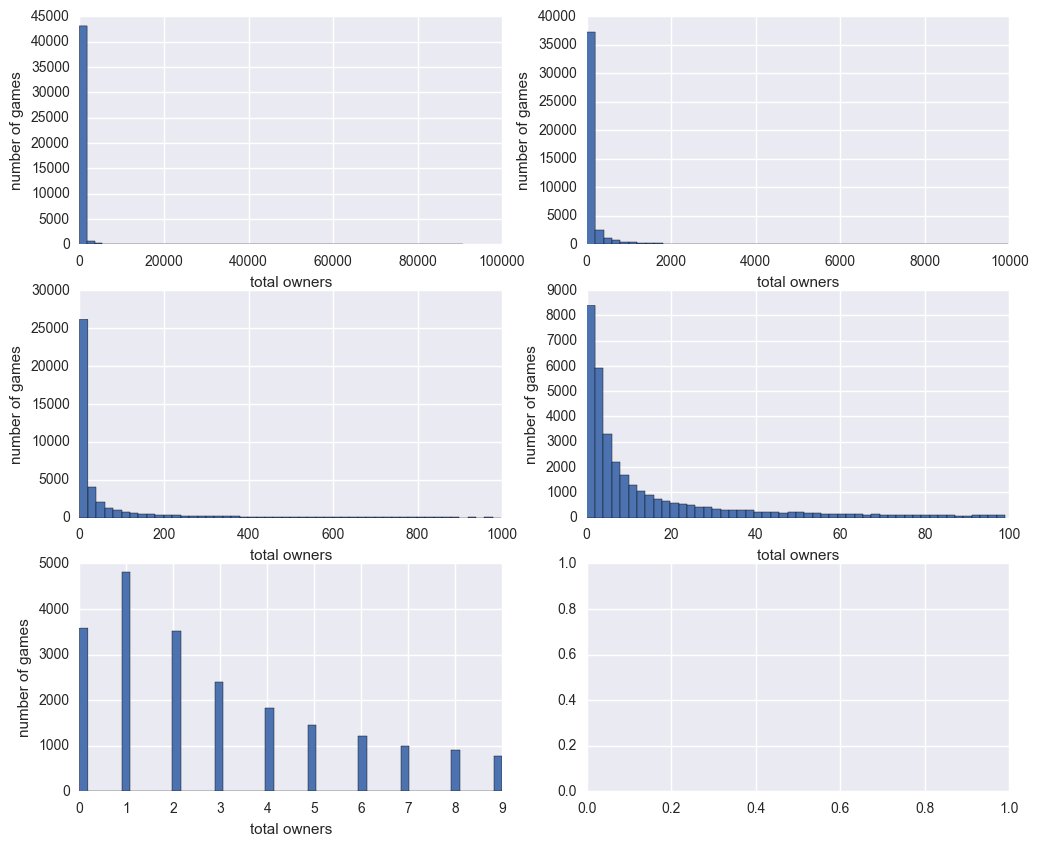

In [6]:
total_owners = games['total_owners']
fig, axs = plt.subplots(3, 2, figsize=(12,10))
axs = axs.reshape(1, -1)[0]
for i in range(5):
    ax = axs[i]
    ax.hist(total_owners[total_owners < 10 ** (5-i)], bins=50)
    ax.set_xlabel('total owners')
    ax.set_ylabel('number of games')

As expect, most of games have less owners and only a few games are very popular.

In [7]:
print('avg of total owners:', total_owners.mean())
print('median of total owners:', total_owners.median())

avg of total owners: 308.94919666098195
median of total owners: 11.0


It is probably not that easy to predict the exact number of total owners, so instead, we predict if a game would be popular, i.e. if the number of its owner is larger than the average number of owners.

In [8]:
games['popular'] = (games['total_owners'] > games['total_owners'].mean()).astype(int)

In [9]:
print('positive ratio: {:.2f}%'.format(games['popular'].sum() / games.shape[0] * 100))

positive ratio: 12.65%


# Determine the performance measure
Accuracy is not a good measure in our case since the labels are highly imbalanced (about 13% of data are labeled postive). A dummy model that label all sample point negative will have a accuracy 87% which is meaningless for perfomance measurement.<br>
In a imaginary businuess case we want to identify the boardgame which would be popular and avoid publishing games which would not, we choose true positive rate (TPR) and false postive rate (FPR) as our measures. Our goal is to find if we can find a good model to maximize TPR while FPR is minimized.

In [10]:
def tpr(y_true, y_pred):
    tp = np.sum((y_pred==1) & (y_true==1))
    p = np.sum(y_true==1)
    return tp / p

In [11]:
def fpr(y_true, y_pred):
    fp = np.sum((y_pred==1) & (y_true!=1))
    n = np.sum(y_true!=1)
    return fp / n

In [12]:
games.loc[:, games.columns[0:21]].dtypes

id                        int64
name                     object
n_names                   int64
yearpublished           float64
description              object
minplayers              float64
maxplayers              float64
playingtime             float64
minplaytime             float64
maxplaytime             float64
minage                  float64
users_rated               int64
average_rating          float64
bayes_average_rating    float64
total_owners              int64
total_traders             int64
total_wanters             int64
total_wishers             int64
total_comments            int64
total_weights             int64
average_weight          float64
dtype: object

In [13]:
# determine the features to draw correlation matrix
features = list(games.columns[0:21])
features.remove('id')
features.remove('name')
features.remove('description')

In [14]:
def corr_plot(corr):
#     # Generate a mask for the upper triangle
#     mask = np.zeros_like(corr, dtype=np.bool)
#     mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=1,
                square=True,linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

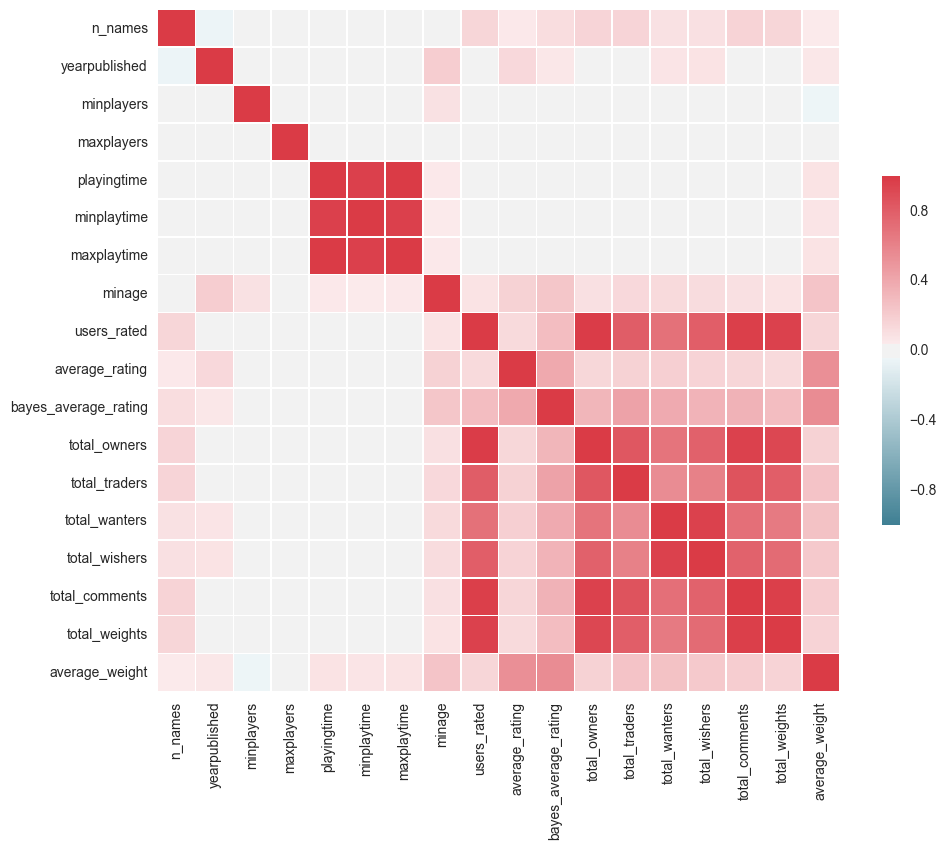

In [15]:
corr_matrix = games[features].corr()

corr_plot(corr_matrix)

In [16]:
abs(corr_matrix['total_owners']).sort_values(ascending=False)

total_owners            1.000000
users_rated             0.985930
total_comments          0.957530
total_weights           0.927475
total_traders           0.836408
total_wishers           0.786393
total_wanters           0.681255
bayes_average_rating    0.321410
average_weight          0.177862
n_names                 0.163764
average_rating          0.143385
minage                  0.094799
yearpublished           0.030341
maxplaytime             0.007394
playingtime             0.007394
minplaytime             0.004397
maxplayers              0.001325
minplayers              0.001301
Name: total_owners, dtype: float64

At least two things we can see from the correlation plot:
<ul>
    <li>`minplaytime`, `maxplaytime` and `playingtime` are highly correlated.</li>
    <li>Many features obtained from users are correlated with `total_owners`, such as `total_traders`, `users_rated`</li>
</ul>
In principal component analysis (PCA), highly correlated features can be compressed into fewer number of features via linear transformation, which helps to reduce the dimensions. However, if the a feature is highly correlated with the target variable, we need to be aware if it is another representation of target variable and which is not accesible when facing unlabeled data.<br>
In our case variables as `total_comments` clearly depend on `total_owners` since more people have a game then more people comment on this game. So we have to filter out this type of variables.<br>

We also need to strike out variables `average_rating` and `bayes_average_rating`, since it is clear that a game with higher rate has more owners (as this information is useless when a new game released), and `average_rating` is not considering the number of votes for giving correct statistical meaning.

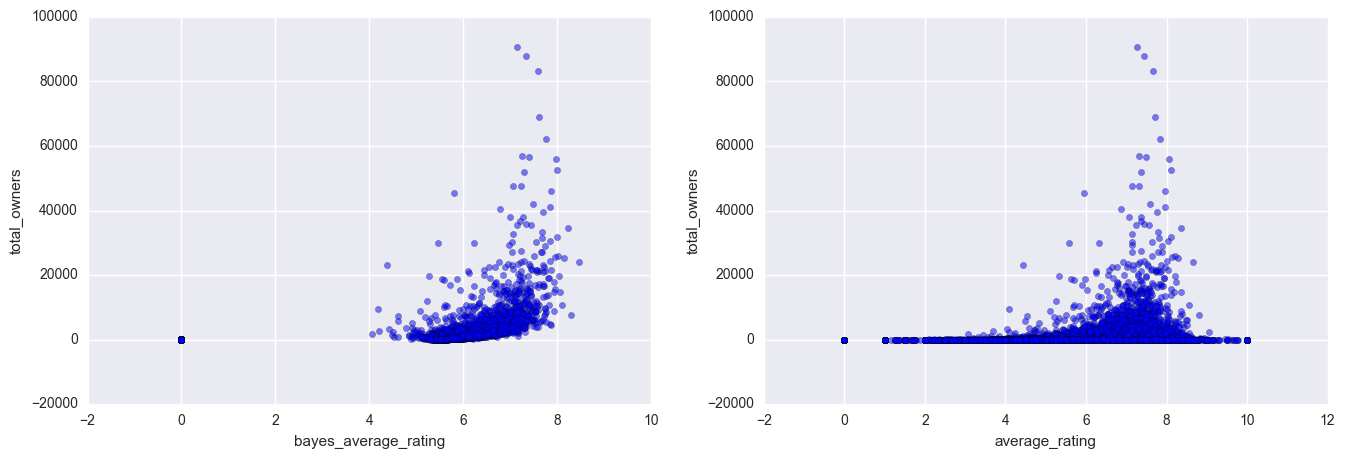

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].scatter(games['bayes_average_rating'], games['total_owners'], alpha=0.5)
axs[1].scatter(games['average_rating'], games['total_owners'], alpha= 0.5)

axs[0].set_xlabel('bayes_average_rating')
axs[1].set_xlabel('average_rating')

axs[0].set_ylabel('total_owners')
axs[1].set_ylabel('total_owners')

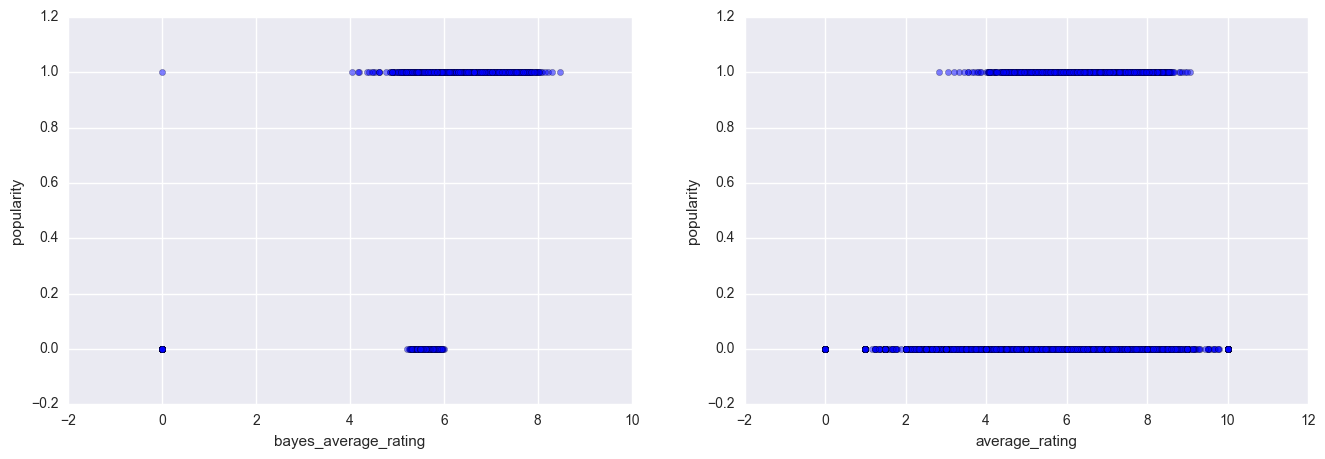

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].scatter(games['bayes_average_rating'], games['popular'], alpha=0.5)
axs[1].scatter(games['average_rating'], games['popular'], alpha=0.5)

axs[0].set_xlabel('bayes_average_rating')
axs[1].set_xlabel('average_rating')

axs[0].set_ylabel('popularity')
axs[1].set_ylabel('popularity')

# Compress features

In [91]:
corr_matrix.loc[['playingtime', 'minplaytime', 'maxplaytime'], ['playingtime', 'minplaytime', 'maxplaytime']]

,playingtime,minplaytime,maxplaytime
playingtime,1.000000,0.967892,1.000000
minplaytime,0.967892,1.000000,0.967892
maxplaytime,1.000000,0.967892,1.000000


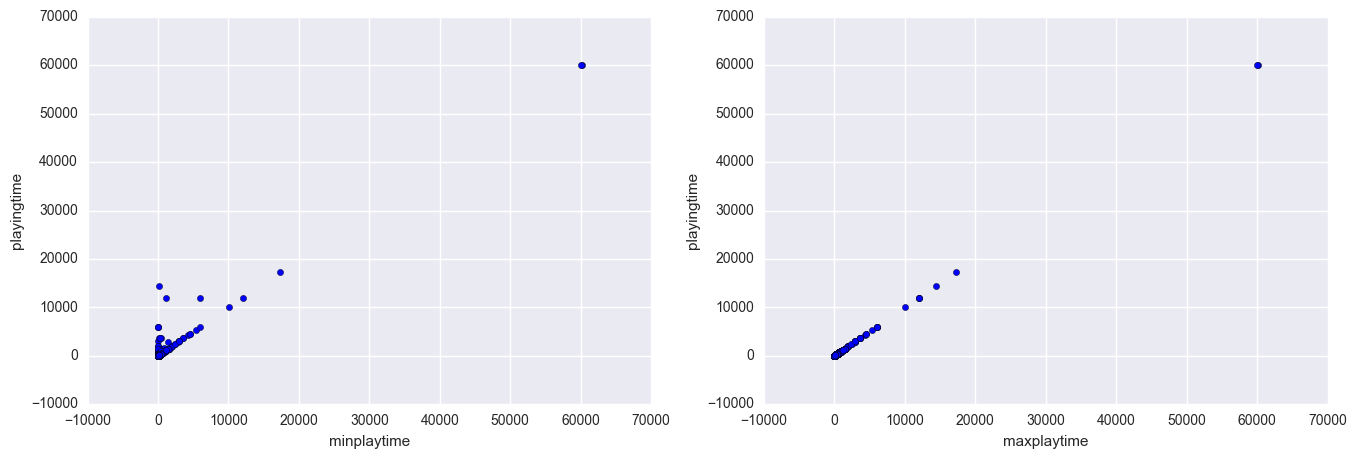

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].scatter(games['minplaytime'], games['playingtime'])
axs[1].scatter(games['maxplaytime'], games['playingtime'])

axs[0].set_xlabel('minplaytime')
axs[1].set_xlabel('maxplaytime')

axs[0].set_ylabel('playingtime')
axs[1].set_ylabel('playingtime')

Finding the principal component is equivalent to diagonalize the covariance matrix, which find a new coordinate where no covariance between new axes (variables). Since in the case of game play time, all three variables have the same scale and unit, so we don't do the standardization before the diagonalization.

In [19]:
time_cov_mat = games[['playingtime', 'minplaytime', 'maxplaytime']].cov()

In [21]:
eigvals, eigvecs = np.linalg.eig(time_cov_mat)

In [22]:
eigvals

array([  5.75455017e+05,  -1.48080734e-11,   8.08366971e+03])

In [23]:
eigvecs

array([[ -5.86971499e-01,  -7.07106781e-01,   3.94289816e-01],
       [ -5.57610006e-01,   5.90313938e-16,  -8.30103055e-01],
       [ -5.86971499e-01,   7.07106781e-01,   3.94289816e-01]])

In [24]:
print('compress ratio: {:2.3f}%'.format(eigvals[0] / eigvals.sum()* 100)) 

compress ratio: 98.615%


In [25]:
games['pc_time'] = ((games[['playingtime', 'minplaytime', 'maxplaytime']].values).dot(-eigvecs[:, 0])).copy()

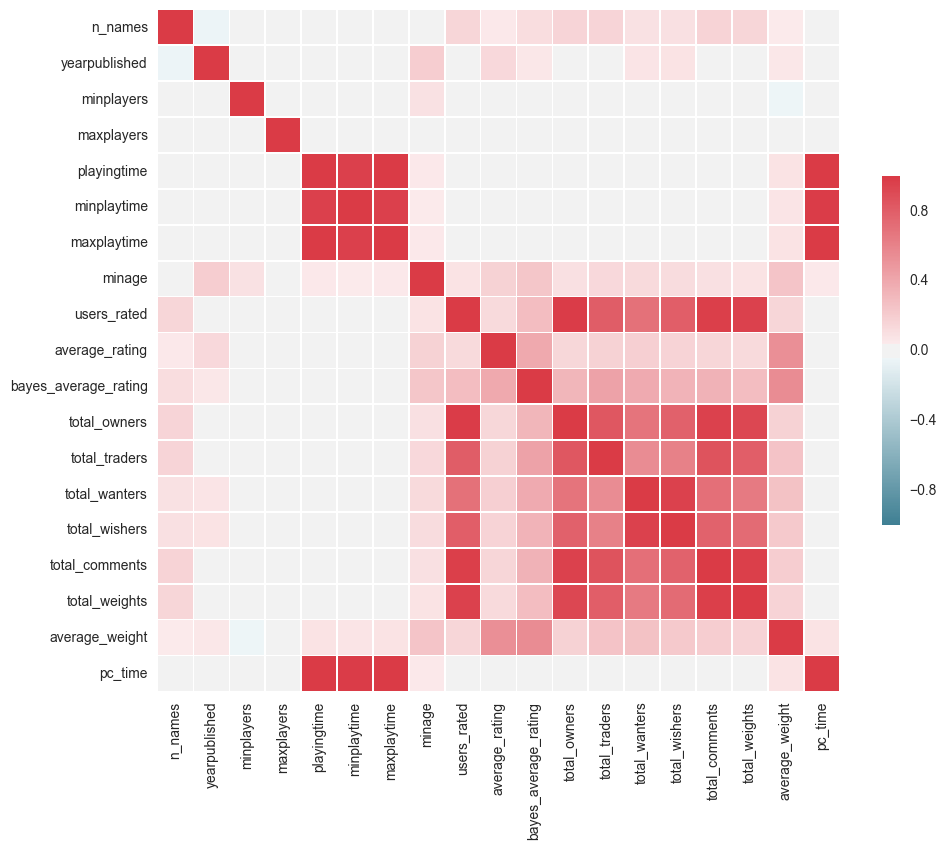

In [26]:
corr_matrix = games[features + ['pc_time']].corr()
corr_plot(corr_matrix)

Now we just strike out the features we don't to use to create the feature matrix `X`.

In [27]:
features = list(games.columns)
unwanted = ['id', 'name', 'description', 'yearpublished', 'minplaytime', 'maxplaytime', 'playingtime', 'users_rated', 'total_owners', 'total_traders',
       'total_wanters', 'total_wishers', 'total_comments', 'total_weights', 'average_rating', 'bayes_average_rating', 'popular']
features = [feature for feature in features if feature not in unwanted]

We separate the data into education set and evaluation set. The education set is using for training and selecting models, and the evaluation set is for the final performance evaluation. The education data is stratified sampled with the assumption that popular games are always about 13% of the total games. The evaluation set is 1/4 of the whole data set which contains around 10000 sample points to guarantee its validity.

In [29]:
X = games[features].copy()
y = games['popular'].copy()

X_educ, X_eval, y_educ, y_eval = sklearn.model_selection.train_test_split(X, y, test_size=1/4, random_state=36, stratify=y)

In [30]:
skf = sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=1020)

Since most of independent variables in our dataset are categorical variables and the target variable has been transformed into classification, models like regression or cluster methods might not be suitable without putting more effort. As we might want to see if we can came out a simple and explanable model, our first choice would be decision tree model. Ensemble models such as random forest or powerful model as neural network could be use later for getting better predictive power with less explainability as a tradeoff.

In [32]:
def tree_cross_test(X, y, skf, max_depth=20):
    # kfold train and test for a tree given max_depth
    # return values are the average tpr and fpr over all cross validation
    clf = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth)

    tprs_train = []
    fprs_train = []
    tprs_test = []
    fprs_test = []
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if len(X.shape) == 1:
            X_train = X_train.reshape(-1, 1)
            X_test = X_test.reshape(-1, 1)
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        tprs_train.append(tpr(y_train, y_train_pred))
        fprs_train.append(fpr(y_train, y_train_pred))
        tprs_test.append(tpr(y_test, y_test_pred))
        fprs_test.append(fpr(y_test, y_test_pred))

    return np.mean(tprs_train), np.mean(fprs_train), np.mean(tprs_test), np.mean(fprs_test)

In [33]:
def depth_test(X, y, start=2, end=5, step=1):
    # kfold test for tree over a range of max_depth test
    # note that grid search api could be used instead to get the power of parallel computation easily
    avgs_tpr_train = []
    avgs_fpr_train = []
    avgs_tpr_test = []
    avgs_fpr_test = []

    depths = [depth for depth in range(start, end, step)]

    for depth in depths:
        avg_tpr_train, avg_fpr_train, avg_tpr_test, avg_fpr_test = tree_cross_test(X, y, skf, depth)

        avgs_tpr_train.append(avg_tpr_train)
        avgs_fpr_train.append(avg_fpr_train)

        avgs_tpr_test.append(avg_tpr_test)
        avgs_fpr_test.append(avg_fpr_test)
    return depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test

In [34]:
def depth_test_visual(depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test):
    # visualize the relation between tree max_depth and performance
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    axs[0].plot(depths, avgs_tpr_train, '-o', label='train')
    axs[0].plot(depths, avgs_tpr_test, '-o', label='test')

    axs[1].plot(depths, avgs_fpr_train, '-o', label='train')
    axs[1].plot(depths, avgs_fpr_test, '-o', label='test')

    axs[0].set_ylabel('tpr')
    axs[1].set_ylabel('fpr')
    
    axs[0].set_xlabel('max depth')
    axs[1].set_xlabel('max depth')

    axs[0].legend()
    axs[1].legend()
    plt.show()

We first fully grow a tree to know the range of maximum depth

In [35]:
tree = sklearn.tree.DecisionTreeClassifier()
tree.fit(X_educ, y_educ)

y_educ_pred = tree.predict(X_educ)
y_eval_pred = tree.predict(X_eval)

In [36]:
def print_tpr_fpr(y_educ, y_educ_pred, y_eval, y_eval_pred):
    print('tpr:')
    print(' education set: {:.2f}%'.format(tpr(y_educ, y_educ_pred) * 100))
    print('evaluation set: {:.2f}%'.format(tpr(y_eval, y_eval_pred) * 100))
    print('\n')
    print('fpr:')
    print(' education set: {:.2f}%'.format(fpr(y_educ, y_educ_pred) * 100))
    print('evaluation set: {:.2f}%'.format(fpr(y_eval, y_eval_pred) * 100))

In [37]:
print_tpr_fpr(y_educ, y_educ_pred, y_eval, y_eval_pred)

tpr:
 education set: 99.86%
evaluation set: 63.26%


fpr:
 education set: 0.00%
evaluation set: 5.89%


In [38]:
tree.tree_.max_depth

37

A range of rough scan can be done to see the relation between depth and performance.

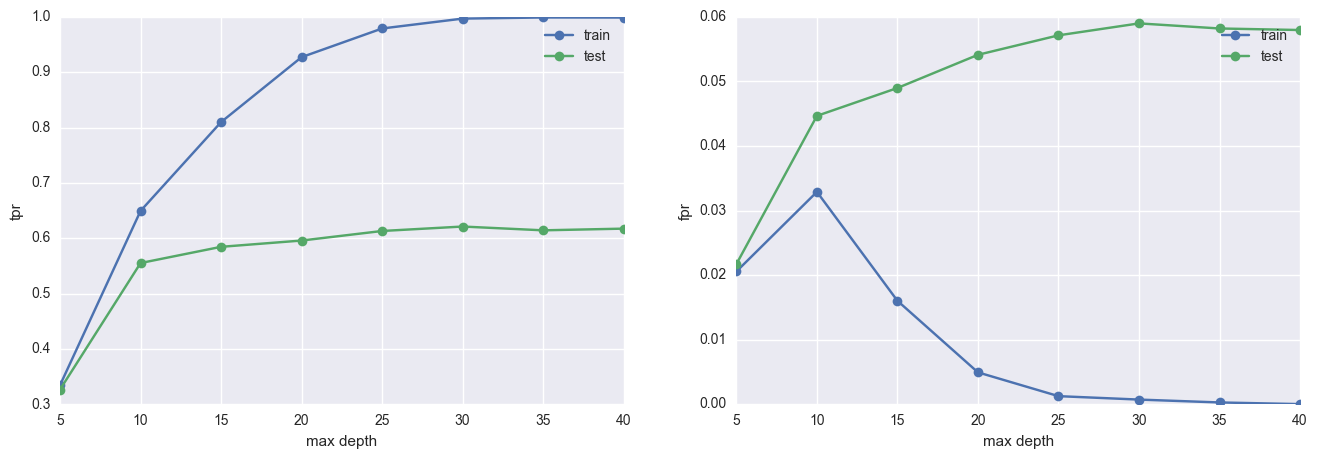

In [44]:
depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test = depth_test(X_educ, y_educ, start=5, end=41, step=5)
depth_test_visual(depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test)

It seems the performance saturate quite early before it grow to the complete tree. The deep layer of tree is probably growing only for very specific games and the leaves contains only a few games.

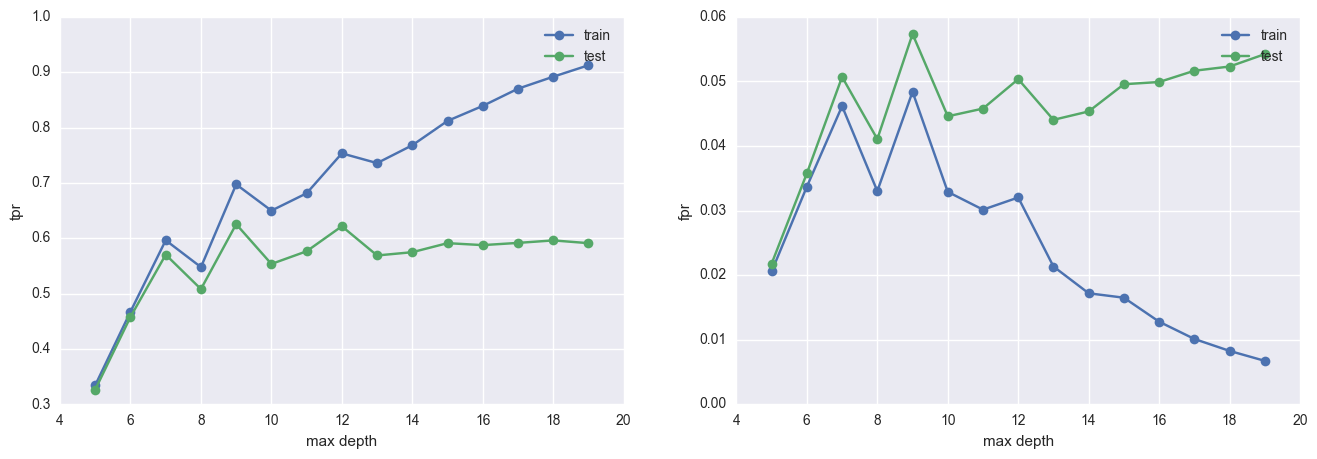

In [40]:
depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test = depth_test(X_educ, y_educ, start=5, end=20, step=1)
depth_test_visual(depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test)

From figure above we see that the model gives us a the near-saturated performance when it is limited to depth 9.

In [41]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=9)
tree.fit(X_educ, y_educ)

y_educ_pred = tree.predict(X_educ)
y_eval_pred = tree.predict(X_eval)

In [43]:
print_tpr_fpr(y_educ, y_educ_pred, y_eval, y_eval_pred)

tpr:
 education set: 65.36%
evaluation set: 60.07%


fpr:
 education set: 4.27%
evaluation set: 4.98%


Though the model is a bit overfitting and the performance is not outstanding, it could still have a good application on business. 60% TPR and 5% FPR means that the model can find about 8 popular games out of 100 games among which only 13 games are real popular while it misidentifies 4 actually unpopular games as popular. A deeper question is, do we have a good explaination for it? We can try to answer this question from checking which feature is the most important one.

In [45]:
importances = pd.Series(data=tree.feature_importances_, index=features)
importances.sort_values(ascending=False).head(10)

average_weight                   0.669765
n_names                          0.174262
minage                           0.065181
Wargame                          0.015058
pc_time                          0.010083
maxplayers                       0.005812
Hand Management                  0.005330
Area Control / Area Influence    0.004638
Card Game                        0.004613
Educational                      0.002348
dtype: float64

The list above showing that `average_weight` extremely dominates other features. Though we expect it plays a role, but the dominance seems not so intuitive. We can try to do the single feature prediction to see if it still play so well.

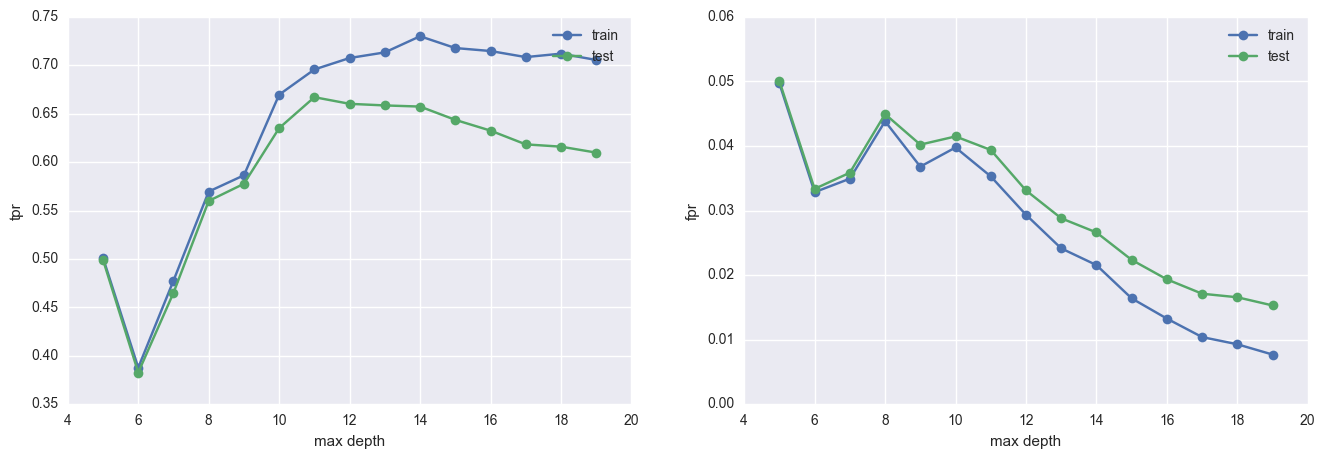

In [46]:
depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test = depth_test(X_educ['average_weight'], y_educ, start=5, end=20, step=1)
depth_test_visual(depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test)

In [47]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=11)
tree.fit(X_educ['average_weight'].reshape(-1,1), y_educ)

y_educ_pred = tree.predict(X_educ['average_weight'].reshape(-1,1))
y_eval_pred = tree.predict(X_eval['average_weight'].reshape(-1,1))

In [48]:
print_tpr_fpr(y_educ, y_educ_pred, y_eval, y_eval_pred)

tpr:
 education set: 70.16%
evaluation set: 69.65%


fpr:
 education set: 3.70%
evaluation set: 4.26%


It turns out that solely a `avererage_weight` gives a similar performace. We further check if that is still true for generalization. We shuffle and split the whole dataset 50 times to eliminate the cause of specific choice of education and evaluation set.

In [49]:
ss = sklearn.model_selection.ShuffleSplit(50, test_size=1/4, random_state=1155)
tree = sklearn.tree.DecisionTreeClassifier(max_depth=11)

tprs_educ, fprs_educ, tprs_eval, fprs_eval = [], [], [], []
for educ_ind, eval_ind in ss.split(X, y):
    X_educ, X_eval = X['average_weight'].iloc[educ_ind], X['average_weight'].iloc[eval_ind]
    y_educ, y_eval = y.iloc[educ_ind], y.iloc[eval_ind]
    
    tree.fit(X_educ.reshape(-1, 1), y_educ)
    
    y_educ_pred = tree.predict(X_educ.reshape(-1, 1))
    y_eval_pred = tree.predict(X_eval.reshape(-1, 1))
    
    tprs_educ.append(tpr(y_educ, y_educ_pred))
    fprs_educ.append(fpr(y_educ, y_educ_pred))
    
    tprs_eval.append(tpr(y_eval, y_eval_pred))
    fprs_eval.append(fpr(y_eval, y_eval_pred))

In [50]:
print('tpr:')
print(' education set: {:.1f}% +/- {:.1f}%'.format(np.mean(tprs_educ) * 100, np.std(tprs_educ) * 100))
print('evaluation set: {:.1f}% +/- {:.1f}%'.format(np.mean(tprs_eval) * 100, np.std(tprs_eval) * 100))
print('\n')
print('fpr:')
print(' education set: {:.1f}% +/- {:.1f}%'.format(np.mean(fprs_educ) * 100, np.std(fprs_educ) * 100))
print('evaluation set: {:.1f}% +/- {:.1f}%'.format(np.mean(fprs_eval) * 100, np.std(fprs_eval) * 100))

tpr:
 education set: 70.2% +/- 3.1%
evaluation set: 67.3% +/- 3.5%


fpr:
 education set: 3.7% +/- 0.4%
evaluation set: 4.0% +/- 0.5%


The result shows that `average_weight` does have the ability to predict game popularity. A reasonable hypothesis is it actually depends on `total_owners`. After some investigation, we found the following figures prove the hypothesis.

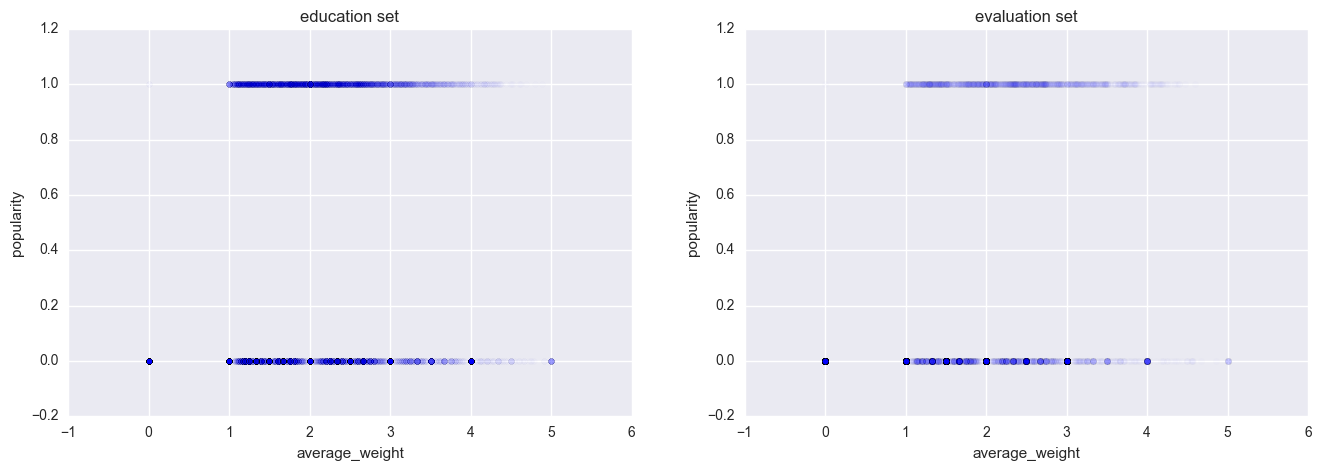

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))
axs[0].scatter(X_educ, y_educ, alpha=0.007)
axs[1].scatter(X_eval, y_eval, alpha=0.01)

axs[0].set_title('education set')
axs[1].set_title('evaluation set')

axs[0].set_xlabel('average_weight')
axs[1].set_xlabel('average_weight')

axs[0].set_ylabel('popularity')
axs[1].set_ylabel('popularity')

Each data point is set to be a bit transparent. A point would have dark color if many data overlap on that point. The plots show that the average weight of unpopular games tend to accumulate around integers and half integers. The reason is following: the average weight is given by average over the votes from users. The choices that users have are integers from 0 to 5, so when a game is voted by a few users, e.g. one or two, the average of that vote would be an integer or half integer. On the other hand, popular games have more owners so as voters, so their average weights will be spread out more evenly compared to unpopular games. That is how `average_weight` reveals the information of popularity.<br>

Now we want to see how worse it would be if we remove `average_weight` from feature list.

In [53]:
features.remove('average_weight')

In [54]:
X = games[features].copy()
y = games['popular'].copy()

X_educ, X_eval, y_educ, y_eval = sklearn.model_selection.train_test_split(X, y, test_size=1/4, random_state=36, stratify=y)

In [55]:
tree = sklearn.tree.DecisionTreeClassifier()
tree.fit(X_educ, y_educ)

y_educ_pred = tree.predict(X_educ)
y_eval_pred = tree.predict(X_eval)

In [56]:
print_tpr_fpr(y_educ, y_educ_pred, y_eval, y_eval_pred)

tpr:
 education set: 96.52%
evaluation set: 40.28%


fpr:
 education set: 0.04%
evaluation set: 8.15%


In [57]:
tree.tree_.max_depth

63

In [58]:
importances = pd.Series(data=tree.feature_importances_, index=features)
importances.sort_values(ascending=False).head(10)

minage                    0.127900
n_names                   0.123217
pc_time                   0.093588
maxplayers                0.059427
minplayers                0.027077
Dice Rolling              0.016734
Set Collection            0.013773
Hand Management           0.013420
Card Game                 0.012903
Variable Player Powers    0.012841
dtype: float64

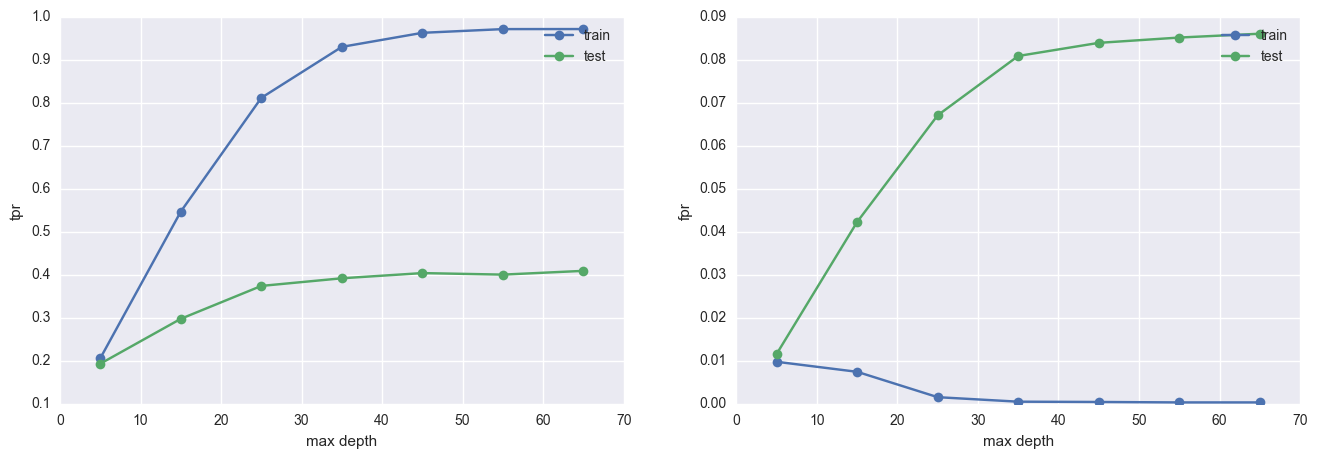

In [59]:
depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test = depth_test(X_educ, y_educ, start=5, end=70, step=10)
depth_test_visual(depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test)

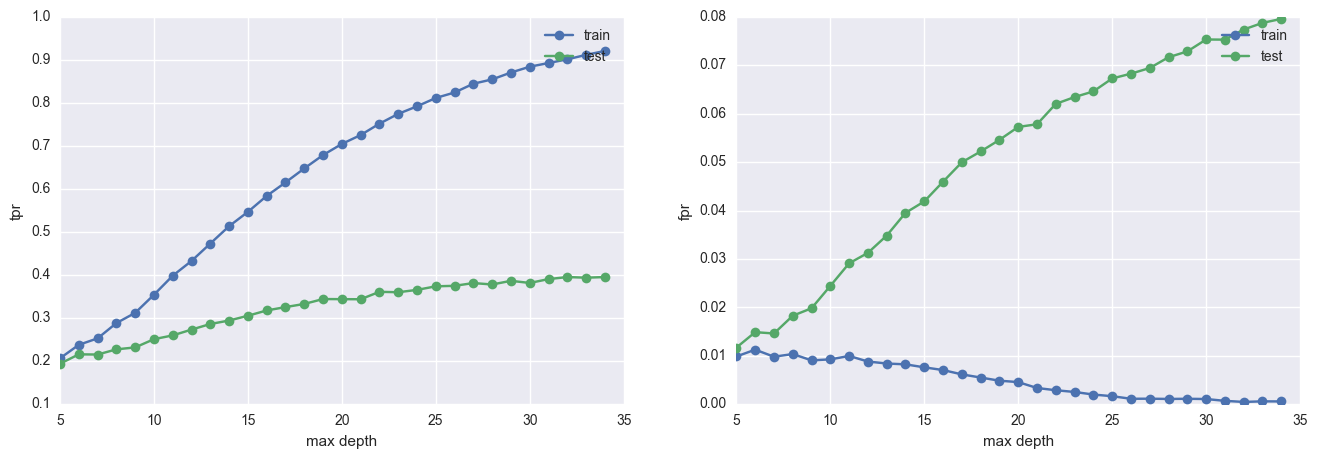

In [60]:
depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test = depth_test(X_educ, y_educ, start=5, end=35, step=1)
depth_test_visual(depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test)

In [65]:
ss = sklearn.model_selection.ShuffleSplit(50, test_size=1/4, random_state=1155)
tree = sklearn.tree.DecisionTreeClassifier(max_depth=35)

tprs_educ, fprs_educ, tprs_eval, fprs_eval = [], [], [], []
for educ_ind, eval_ind in ss.split(X, y):
    X_educ, X_eval = X.iloc[educ_ind], X.iloc[eval_ind]
    y_educ, y_eval = y.iloc[educ_ind], y.iloc[eval_ind]
    
    tree.fit(X_educ, y_educ)
    
    y_educ_pred = tree.predict(X_educ)
    y_eval_pred = tree.predict(X_eval)
    
    tprs_educ.append(tpr(y_educ, y_educ_pred))
    fprs_educ.append(fpr(y_educ, y_educ_pred))
    
    tprs_eval.append(tpr(y_eval, y_eval_pred))
    fprs_eval.append(fpr(y_eval, y_eval_pred))

In [66]:
print('tpr:')
print(' education set: {:.1f}% +/- {:.1f}%'.format(np.mean(tprs_educ) * 100, np.std(tprs_educ) * 100))
print('evaluation set: {:.1f}% +/- {:.1f}%'.format(np.mean(tprs_eval) * 100, np.std(tprs_eval) * 100))
print('\n')
print('fpr:')
print(' education set: {:.1f}% +/- {:.1f}%'.format(np.mean(fprs_educ) * 100, np.std(fprs_educ) * 100))
print('evaluation set: {:.1f}% +/- {:.1f}%'.format(np.mean(fprs_eval) * 100, np.std(fprs_eval) * 100))

tpr:
 education set: 92.3% +/- 1.1%
evaluation set: 41.0% +/- 1.4%


fpr:
 education set: 0.1% +/- 0.0%
evaluation set: 8.1% +/- 0.3%


Things go as what we expect. TPR drops to 40%, which is not good at all. Moreover, except `average_weight`, another feature `n_names` might also depend on `total_owners` since more popular a game is, more international versions a game has. (Note that the dependencies of `average_weight` and `n_names` on `total_owners` are still observations and hypotheses. We need a more rigorous analysis to back them up.)

In [67]:
features.remove('n_names')

In [68]:
X = games[features].copy()
y = games['popular'].copy()

X_educ, X_eval, y_educ, y_eval = sklearn.model_selection.train_test_split(X, y, test_size=1/4, random_state=36, stratify=y)

In [69]:
tree = sklearn.tree.DecisionTreeClassifier()
tree.fit(X_educ, y_educ)

y_educ_pred = tree.predict(X_educ)
y_eval_pred = tree.predict(X_eval)

In [70]:
print_tpr_fpr(y_educ, y_educ_pred, y_eval, y_eval_pred)

tpr:
 education set: 94.32%
evaluation set: 31.91%


fpr:
 education set: 0.04%
evaluation set: 10.44%


In [71]:
tree.tree_.max_depth

66

In [72]:
importances = pd.Series(data=tree.feature_importances_, index=features)
importances.sort_values(ascending=False).head(10)

pc_time            0.113982
minage             0.104760
maxplayers         0.066426
minplayers         0.031881
Dice Rolling       0.016893
Set Collection     0.016383
Hand Management    0.014843
Card Game          0.014728
Print & Play       0.013837
Auction/Bidding    0.013120
dtype: float64

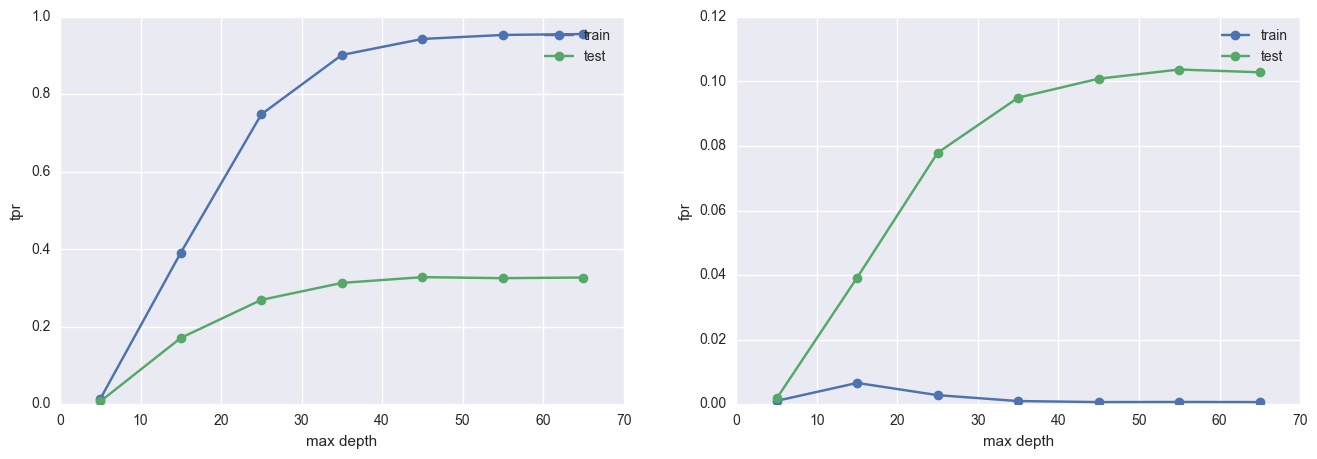

In [73]:
depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test = depth_test(X_educ, y_educ, start=5, end=70, step=10)
depth_test_visual(depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test)

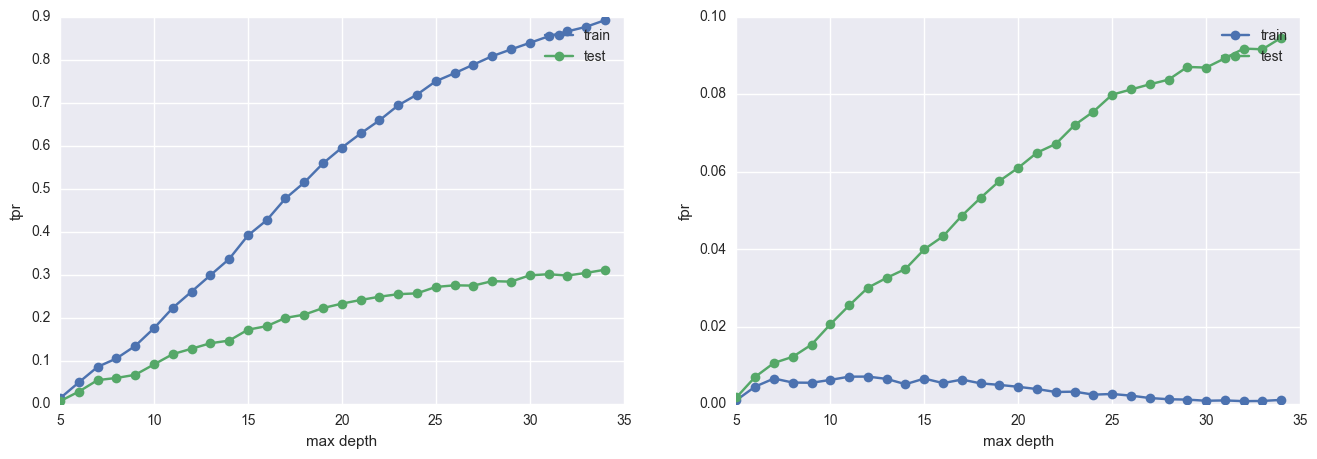

In [74]:
depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test = depth_test(X_educ, y_educ, start=5, end=35, step=1)
depth_test_visual(depths, avgs_tpr_train, avgs_fpr_train, avgs_tpr_test, avgs_fpr_test)

In [75]:
ss = sklearn.model_selection.ShuffleSplit(50, test_size=1/4, random_state=1155)
tree = sklearn.tree.DecisionTreeClassifier(max_depth=45)

tprs_educ, fprs_educ, tprs_eval, fprs_eval = [], [], [], []
for educ_ind, eval_ind in ss.split(X, y):
    X_educ, X_eval = X.iloc[educ_ind], X.iloc[eval_ind]
    y_educ, y_eval = y.iloc[educ_ind], y.iloc[eval_ind]
    
    tree.fit(X_educ, y_educ)
    
    y_educ_pred = tree.predict(X_educ)
    y_eval_pred = tree.predict(X_eval)
    
    tprs_educ.append(tpr(y_educ, y_educ_pred))
    fprs_educ.append(fpr(y_educ, y_educ_pred))
    
    tprs_eval.append(tpr(y_eval, y_eval_pred))
    fprs_eval.append(fpr(y_eval, y_eval_pred))

In [76]:
print('tpr:')
print(' education set: {:.1f}% +/- {:.1f}%'.format(np.mean(tprs_educ) * 100, np.std(tprs_educ) * 100))
print('evaluation set: {:.1f}% +/- {:.1f}%'.format(np.mean(tprs_eval) * 100, np.std(tprs_eval) * 100))
print('\n')
print('fpr:')
print(' education set: {:.1f}% +/- {:.1f}%'.format(np.mean(fprs_educ) * 100, np.std(fprs_educ) * 100))
print('evaluation set: {:.1f}% +/- {:.1f}%'.format(np.mean(fprs_eval) * 100, np.std(fprs_eval) * 100))

tpr:
 education set: 92.3% +/- 0.9%
evaluation set: 32.9% +/- 1.2%


fpr:
 education set: 0.1% +/- 0.0%
evaluation set: 9.5% +/- 0.3%


The result shows that if we remove the variables depending on `tota_owners`, our simple decision tree model can only have 33% TPR with 10% FPR. To get a model with better performance, followings are possible methods:
<ul>
    <li>Apply traditional statisitical method to analyze the dataset, like making hypothesis testing on different group.</li>
    <li>Get more features such as applying bag of word on descriptions and names.</li>
    <li>Get the price of each game online</li>
    <li>Try different hyperparameters of decision tree like min_sample_splits or min_impurity_split to prune the tree better.</li>
    <li>Try other algorithms such as random forest or neural network</li>
</ul>

In [78]:
os.system('jupyter nbconvert --to html 01_modeling.ipynb')

0